In [11]:
try:
    import torch
    import torchvision
    import torchvision.transforms as transforms
    import matplotlib.pyplot as plt
    import torch.nn as nn
    import torch.nn.functional as F
except ModuleNotFoundError as e:
    !pip3 install matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Train our first MLP to classify images

In this section, you will train your first Multi-Layer Perceptronon the MNIST dataset: it is "Hello World" of deep learning.

MNIST consists of 60,000 training images and 10,000 test images, each showing a handwritten digit from 0 to 9 (10 classes in total).

Each image is grayscale, with a resolution of 28×28 pixels. We'll flatten each image into a 1D array of size 784 to feed into our neural network.

We'll go through the full training pipeline, including:

1. Downloading the dataset
2. Preprocessing the data
3. Setting up the DataLoader
4. Defining and initializing the model
5. Choosing a loss function
6. Setting up the optimizer
7. Writing and running the training loop


## Initialize dataset and dataloader

We begin by setting up the training and test datasets.

Each image is transformed using normalization to ensure they share the same distribution, which helps the model train more effectively.

We then create **DataLoaders** for both sets, using a **batch size of 128**.

In [12]:
# 1. Normalize MNIST: mean=0.1307, std=0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. Download and transform MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# 3. Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

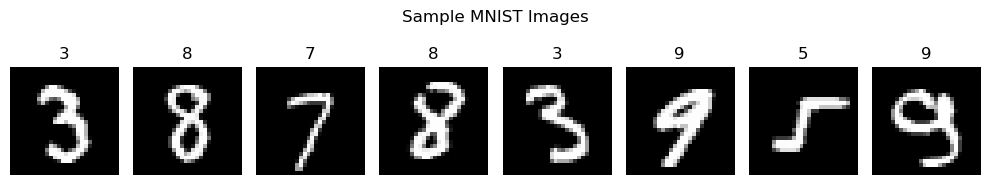

In [13]:
# 4. Get one batch
images, labels = next(iter(train_loader))  # images shape: (8, 1, 28, 28)

# 5. Plot the images
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i][0], cmap='gray')  # images[i] has shape (1, 28, 28)
    plt.title(str(labels[i].item()))
    plt.axis('off')
plt.suptitle("Sample MNIST Images")
plt.tight_layout()
plt.show()


## Model definition
We define a Multi-Layer Perceptron with three layers, applying a ReLU activation function after each layer to introduce non-linearity.

In [14]:
# Define the MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)     # hidden to hidden
        self.fc3 = nn.Linear(64, 10)      # hidden to output (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten input (batch_size, 784)
        x = F.relu(self.fc1(x))           # first hidden layer + ReLU
        x = F.relu(self.fc2(x))           # second hidden layer + ReLU
        x = self.fc3(x)                   # output logits
        return x

## Test random initialized model

Let's test the model with random initialized weight to look at its ouput.

In [35]:
# Instantiate a model, by default the weight are random initialized
model = MLP()
# Get one batch of images, so the input and aoutput pairs. 
images, labels = next(iter(test_loader))  # images shape: (128, 1, 28, 28)

with torch.no_grad():
    # Get just the first image
    x = images[0]
    y = labels[0]
    output = model(x.flatten().unsqueeze(0))
    # Convert the model's output into a probability distribution where the neuron outputs sum to 1.0.
    probs = F.softmax(output, dim=1) 
    slide
    for i in range(10):
        print(f"p(class={i}): {round(probs[0][i].item(),2)}")
    print("Predicted class:", torch.argmax(probs, dim=1).item())
    print("True class:",y.item())

p(class=0): 0.11
p(class=1): 0.09
p(class=2): 0.11
p(class=3): 0.11
p(class=4): 0.1
p(class=5): 0.11
p(class=6): 0.1
p(class=7): 0.11
p(class=8): 0.09
p(class=9): 0.09
Predicted class: 2
True class: 2


## Setup training preliminaries:

- [x] DataLoader
- [x] Model
- [ ] Loss function
- [ ] Optimizer
- [ ] Training loop

## Classification accuracy
While cross-entropy loss measures the difference between the model’s predicted probability distribution and the true distribution, it doesn't directly tell us how often the model gets the answer right.

To evaluate performance more intuitively, we define a function to compute classification accuracy:
For each prediction, we select the class with the highest predicted probability and compare it to the ground truth label.

In [36]:
def evaluate(model, dataloader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = x.view(x.size(0), -1)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [37]:
# Setup the optimizer and pass the model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# Setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
 
losses = []
performance = []

In [38]:
from time import time
for epoch in range(10):
    start=time()
    model.train()
    loss_epoch = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.view(batch_x.size(0), -1)  # flatten
        # TODO: set gradient optimizer to zero
        # TODO: evaluate the batch_x input to get the output
        # TODO: calculate the loss function
        # TODO: get the gradient with backward step
        # TODO: optimization step
        optimizer.zero_grad()
        y_predicted = model(batch_x)
        l = loss_fn(y_predicted, batch_y)
        l.backward()
        optimizer.step()
        loss_epoch += l.item()
    end = time()-start
    accuracy = evaluate(model, test_loader)
    print(f"Epoch {epoch}, Loss: {loss_epoch:.4f}, Accuracy: {accuracy:.4f}, Epoch runtime {end:.4f}")
    losses.append(loss_epoch)
    performance.append(accuracy)

Epoch 0, Loss: 1061.8142, Accuracy: 0.2966, Epoch runtime 6.0470
Epoch 1, Loss: 999.9520, Accuracy: 0.5526, Epoch runtime 4.9741
Epoch 2, Loss: 889.0394, Accuracy: 0.6737, Epoch runtime 4.9986
Epoch 3, Loss: 723.5571, Accuracy: 0.7498, Epoch runtime 4.9760
Epoch 4, Loss: 551.9203, Accuracy: 0.7972, Epoch runtime 5.0578
Epoch 5, Loss: 426.8517, Accuracy: 0.8205, Epoch runtime 5.4950
Epoch 6, Loss: 350.0527, Accuracy: 0.8408, Epoch runtime 5.3406
Epoch 7, Loss: 302.3524, Accuracy: 0.8554, Epoch runtime 5.2283
Epoch 8, Loss: 270.4163, Accuracy: 0.8640, Epoch runtime 5.2477
Epoch 9, Loss: 247.6580, Accuracy: 0.8716, Epoch runtime 6.3717


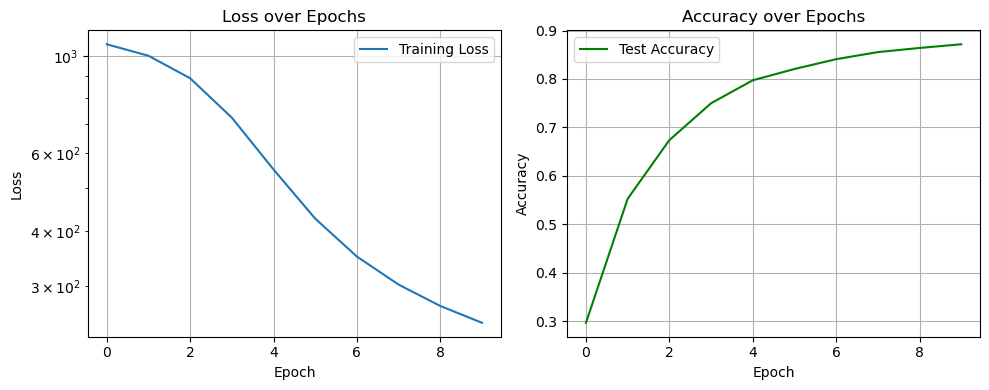

In [45]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Training Loss")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(performance, label="Test Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
